## The plan for this notebook
- Inpsect the data for dtypes and missing values
- Inspect the `date` feature in both the train and test sets
- Inspect the distributions of the label columns, including how they evolve over time
- Inspect the features (dtypes include float, int, and object) to learn about their distributions and unique values.
  - Most of the features are categorical (dtype=object), and most of those are binary.
  - I found some features that were fixed at a single value, so they are not useful in prediction.
  - (Optional) Save plots of all other features vs the label variables. Those can be helpful in understanding the "driver" of the label variables.
- Visualize pair-correlations and identify highly correlated features (corr > 0.8).
  - For each pair that are highly correlated drop one of the pair. This should help get some handle on multicollinearity (and overfitting).
- Output a list of features to drop due to single value or correlation issues.

## To Do
- Outlier detection and additional feature engineering. Both are important parts of developing forecasting models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
from tqdm import tqdm

from utils import (analyze_column_uniques,
                   inspect_unique_values,
                   plot_x_by_labels,
                   inspect_features_correlations,
                   get_highly_correlated_features)
                   

## Load and inspect the train and test sets

In [2]:
data = pd.read_csv('data/dataset.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Columns: 314 entries, date to treatment
dtypes: float64(13), int64(15), object(286)
memory usage: 10.4+ MB


In [4]:
# Inspect training dataset; notice columns dtypes(count): float64(13), int64(15), object(286)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Columns: 314 entries, date to treatment
dtypes: float64(13), int64(15), object(286)
memory usage: 10.4+ MB


In [5]:
data.head()

,date,cnYOuf,ve5O2C,DEOvZC,a51Gwb,cYH551,8mxB5o,yLxGNB,IcdFqB,9QdiG3,...,QRG6IW,DYDCl6,T3A7ZE,WWuNIn,8ylhZT,NETzb9,CSsMhe,zxPLIX,total_cost,treatment
0,20200930,No,No,No,No,No,No,No,No,No,...,0.37,0.63,1.00,1.00,59.4,9,1.000000,0.368421,2480.981429,1
1,20200930,Yes,Yes,No,No,No,No,No,No,No,...,0.32,0.68,1.00,1.00,53.9,9,1.000000,0.666667,2954.071429,1
2,20200930,No,No,No,No,No,No,No,No,No,...,0.01,0.09,10181.50,0.89,46.2,9,0.071429,0.214286,11646.244290,1
3,20200930,No,No,No,No,No,No,No,No,No,...,0.58,0.02,1251.03,0.40,35.7,9,1.000000,0.214286,2872.651429,0
4,20200930,No,No,No,No,No,No,No,No,No,...,1.00,0.00,1.00,1.00,27.8,9,1.000000,0.214286,1317.148095,1


In [6]:
# NA count in the dataset?
total_na = data.isna().sum().sum() 
print(f'NA Count: {total_na}')

NA Count: 0


## Inspect the dates
Timestamps correspond to the end of the month starting `2020-09-30` and ending on `2021-12-31`. The number of observations increases as a function (seemingly quadratic) of time.

Maybe more users are signing up over time.

In [7]:
# set appropriate dtype for the date column
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
print(data['date'].dtype)
list(data['date'].unique())

datetime64[ns]


[Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-10-31 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-09-30 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-31 00:00:00')]

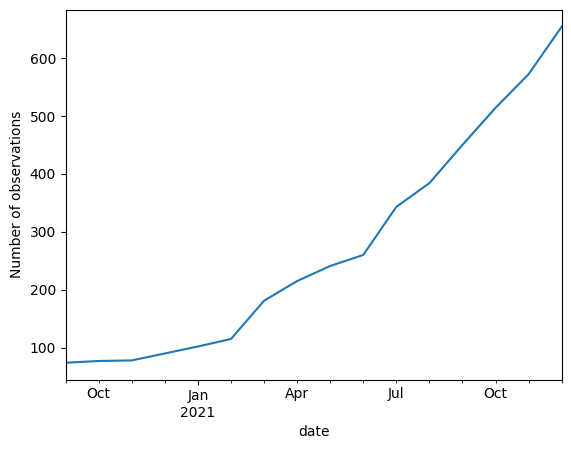

In [8]:
# Plot count of observations in the dataset over time (strong postive trend!)
ax = data.groupby('date')['cnYOuf'].count().plot()
ax.set_ylabel("Number of observations");

## Inspect the distributions of total_cost, treatment
`total_cost` is continous numeric, while `treatment` is binary.

In [9]:
# Inspect the moments and quantiles
data['total_cost'].describe()

count     4350.000000
mean      3996.601951
std       4377.872757
min          1.000000
25%       1049.184231
50%       2505.392337
75%       5813.654062
max      32588.940000
Name: total_cost, dtype: float64

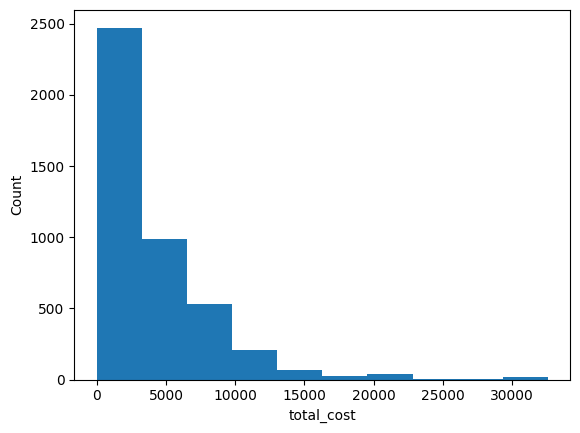

In [10]:
plt.hist(data['total_cost'])
plt.ylabel('Count')
plt.xlabel('total_cost');

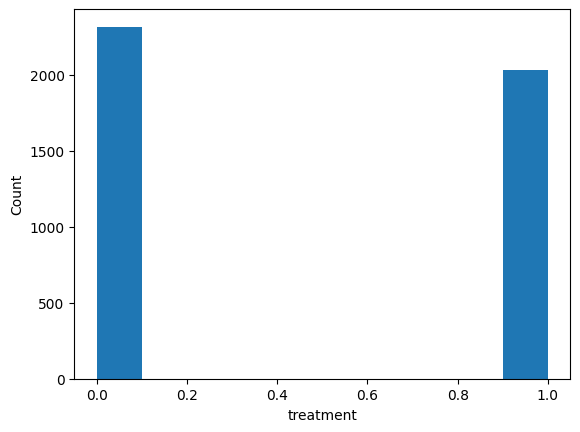

In [11]:
plt.hist(data['treatment'])
plt.ylabel('Count')
plt.xlabel('treatment');

Median total_cost at treatment = 1 is 1482.99
Median total_cost at treatment = 0 is 3568.58


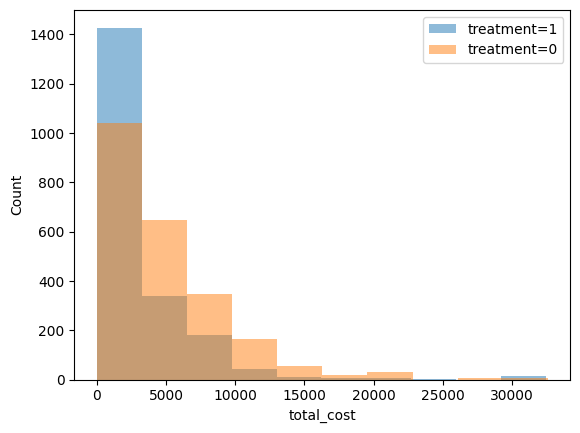

In [12]:
plt.hist(data[data['treatment']==1]['total_cost'], alpha=0.5, label='treatment=1')
plt.hist(data[data['treatment']==0]['total_cost'], alpha=0.5, label='treatment=0')
plt.xlabel('total_cost')
plt.ylabel('Count')
plt.legend();
m1 = data[data['treatment']==1]['total_cost'].median()
m0 = data[data['treatment']==0]['total_cost'].median()
print(f'Median total_cost at treatment = 1 is {np.round(m1, 2)}')
print(f'Median total_cost at treatment = 0 is {np.round(m0, 2)}')

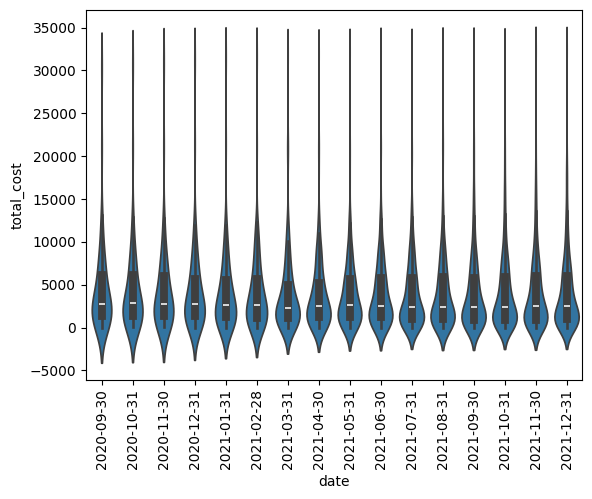

In [13]:
#plt.scatter(data_train['prediction_date'], data_train['total_cost_future'])
sns.violinplot(x='date', y='total_cost', data=data)
plt.xticks(rotation=90);

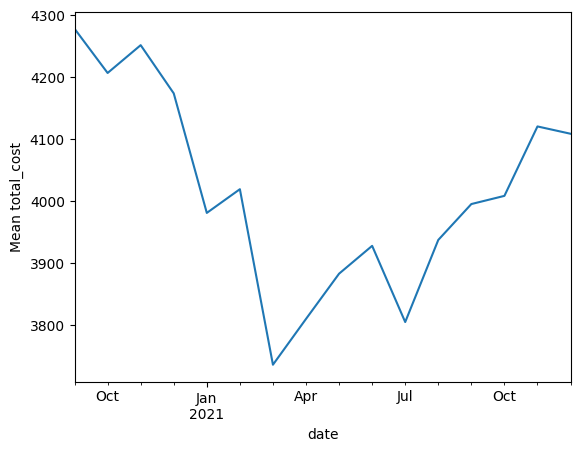

In [14]:
grouped_data = data.groupby('date')['total_cost'].mean()  
grouped_data.plot(ylabel='Mean total_cost');

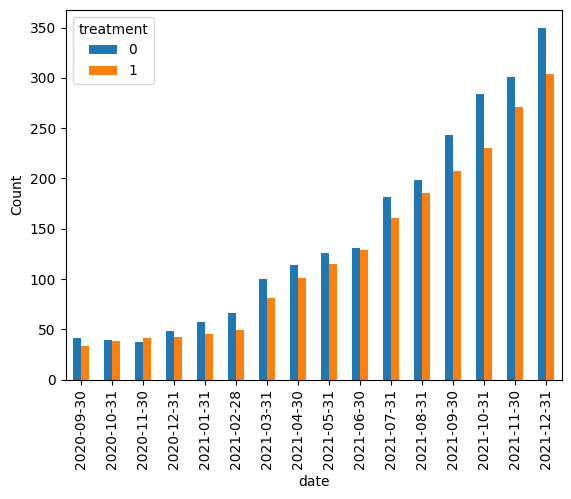

In [15]:
# monthly counts of treatment (1) vs no treatment (0)
# the ratio of 1 to seems to stabalize in recent months 

grouped_data = (
    data.groupby('date')['treatment']
    .value_counts()  
    .unstack()
)
assert grouped_data.sum().sum() == len(data)
ax = grouped_data.plot(kind='bar')
ax.set_xticklabels(pd.Series(grouped_data.index).dt.date);
ax.set_ylabel('Count');

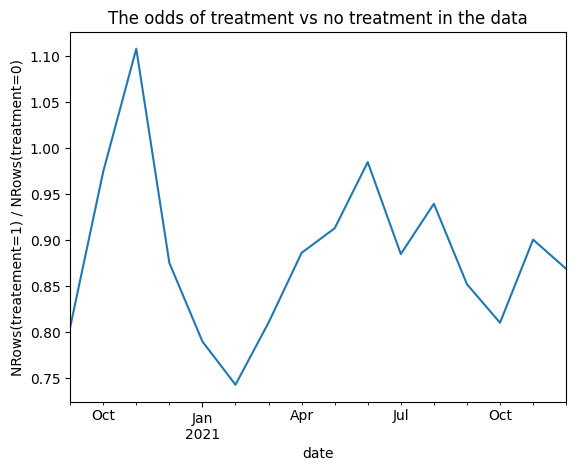

In [16]:
# plot the ratio of counts: where treatment__mental_health=1 to number to where treatment__mental_health=1
(grouped_data[1] /grouped_data[0]).plot(title='The odds of treatment vs no treatment in the data', 
                                        ylabel='NRows(treatement=1) / NRows(treatment=0)');
# The odds seem to be slightly in favor of treatment in the last few months.

## Inspect the features
Recall columns dtype(count), which include the date and labels columns: 
- float64(13)
- int64(15)
- object(286)

In [17]:
remove_cols = ['treatment', 'total_cost', 'date']
col_names = list(data.columns)
[col_names.remove(r) for r in remove_cols]
assert len(col_names) == 311

In [18]:
# get dtype and number of unique values per column
col_stats = analyze_column_uniques(data[col_names])
col_stats

,Column Name,Dtype,Unique Values
0,cnYOuf,object,2
1,ve5O2C,object,2
2,DEOvZC,object,2
3,a51Gwb,object,2
4,cYH551,object,2
...,...,...,...
306,WWuNIn,float64,101
307,8ylhZT,float64,622
308,NETzb9,int64,24
309,CSsMhe,float64,11


In [19]:
# Inspect the int columns; notice none are binary
int_columns = data[col_names].select_dtypes(include=['int']).columns
print('Integer columns unique values counts:\n')
print('Column Unique Values')
for col in int_columns:
    print(col, data[col].nunique())

Integer columns unique values counts:

Column Unique Values
0kIEVg 53
MNLun9 142
2lah94 170
lmP8Wk 121
FYdIWe 146
hrNBHN 7
FtWos4 58
srn0ks 22
bTWcvo 15
QGwvZy 56
o67jnC 19
AJMR2P 23
NETzb9 24


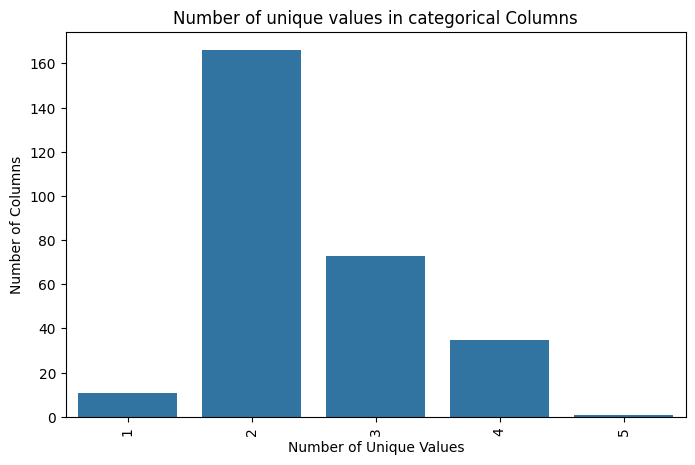

In [20]:
# Inpect the distribution of unique values in object type columns
# How many columns had 1 unique value, 2 unique values, 3 unique values, ....
object_col_stats = col_stats[col_stats['Dtype']=='object'].copy()
col_freq = object_col_stats.groupby(['Unique Values'])['Dtype'].count()
col_freq = col_freq.reset_index().rename(columns={'Unique Values': 'Number of Unique Values', 
                                                  'Dtype': 'Number of Columns'})
plt.figure(figsize=(8, 5))
sns.barplot(col_freq, x='Number of Unique Values', y='Number of Columns')
plt.title('Number of unique values in categorical Columns')
plt.xticks(rotation=90);

In [21]:
# these columns have a single value recorded! Not useful in forecasting
one_value_columns = col_stats[col_stats['Unique Values']==1]['Column Name']
for col in one_value_columns:
    print(col, data[col].unique())

Wk8vc0 ['No']
Ri2tU6 ['No']
emL0kF ['No']
jZqk0W ['Yes']
xh88lD ['Yes']
VAbufe ['No']
sjnHDK ['No']
k7nIer ['No']
D1UJ4x ['No']
8COlTR ['No']
KcHYuJ ['No']


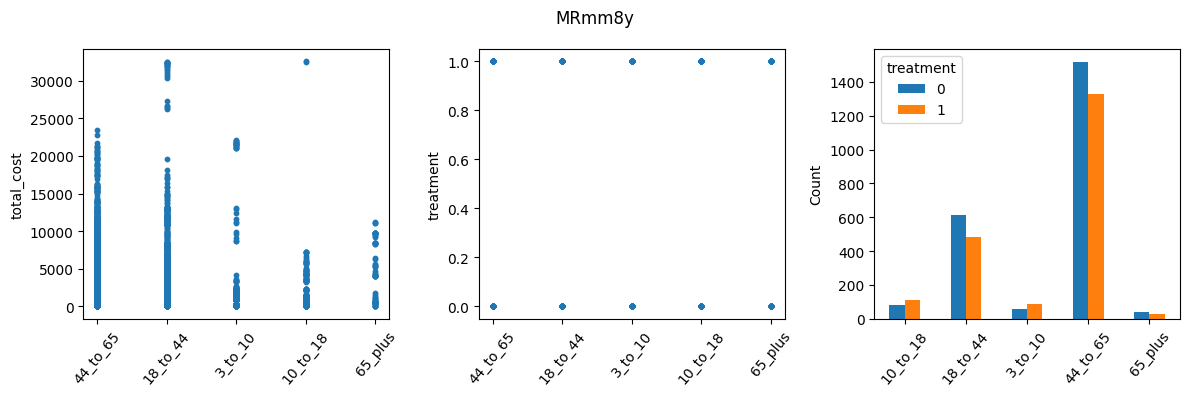

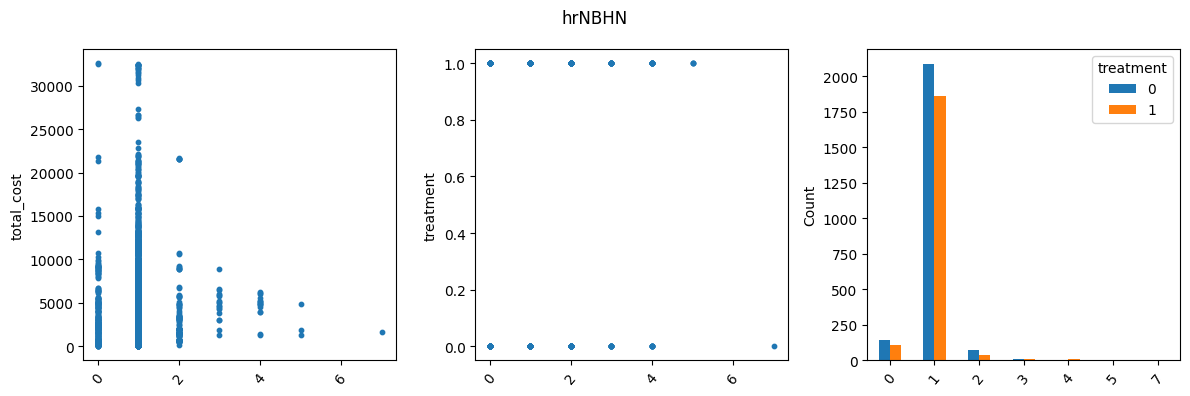

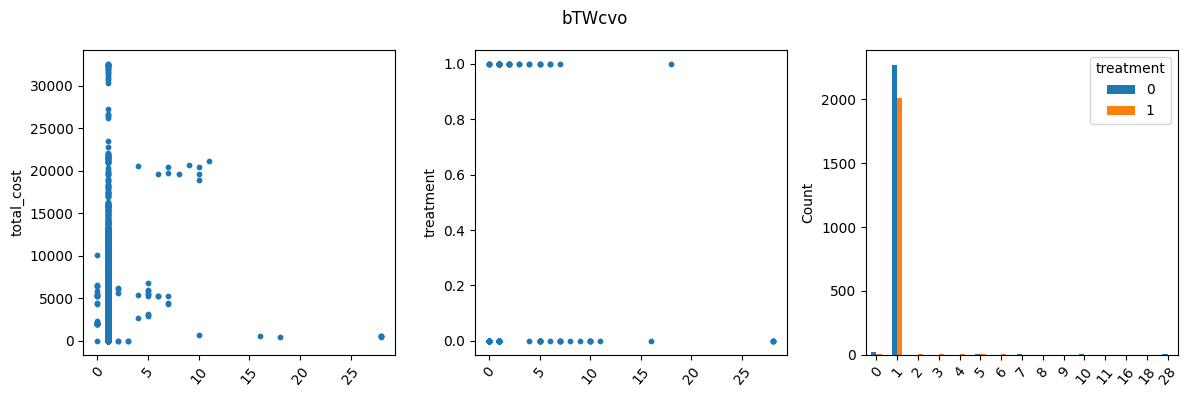

In [22]:
# inspect the relationships between some predictors and the labels
plot_x_by_labels(data, 'MRmm8y', save_plot=True)
plot_x_by_labels(data, 'hrNBHN', save_plot=True)
plot_x_by_labels(data, 'bTWcvo', save_plot=True)

In [23]:
# uncomment the block of code below to output png files of every feature

# for x in tqdm(col_names):
#     plot_x_by_outcomes(data_train, x, save_plot=True)
#     time.sleep(0.1)
#     plt.close()

## Inspect pair correlations among the features in both the train and test sets


Number of remaining columns: 275


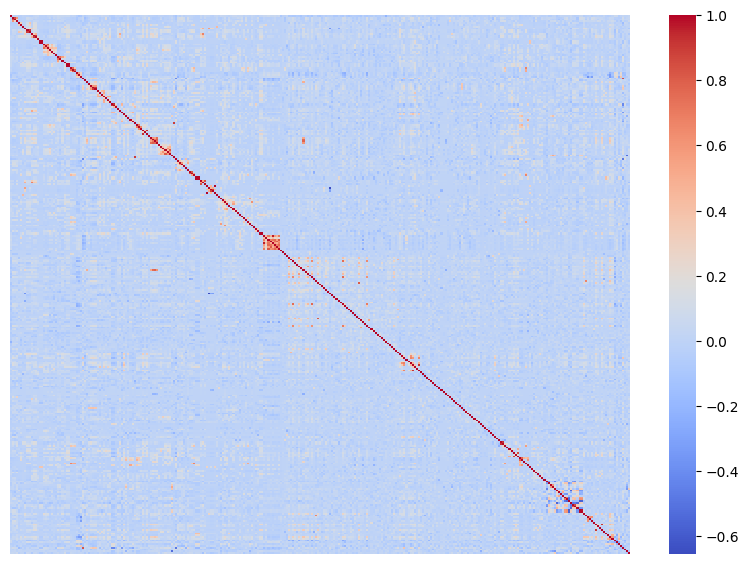

In [24]:
# first eliminate columns that have a single value each
drop_columns_single_value = [
        'Wk8vc0',
        'Ri2tU6',
        'emL0kF',
        'jZqk0W',
        'xh88lD',
        'VAbufe',
        'sjnHDK',
        'k7nIer',
        'D1UJ4x',
        '8COlTR',
        'KcHYuJ',
    ]

drop_columns = drop_columns_single_value + ['total_cost', 'treatment']
corr= inspect_features_correlations(data, drop_columns)

In [25]:
corr_features = get_highly_correlated_features(corr)

Highly Correlated Features (above 0.8):
cnYOuf  ve5O2C    0.862976
IcdFqB  9QdiG3    0.901158
jwsODt  goZivM    0.913950
nYITGF  9D21vH    1.000000
tcR1Jj  9Jjl6X    1.000000
MRmm8y  8ylhZT    0.826973
qItV0S  vYU7fI    0.908696
bcCjX9  nZyguo    0.925562
ML1hbj  b5rJ0h    0.894014
KG1hro  OHZ61e    0.933178
9SpEtB  1Vjd3F    0.803648
8mOfef  FPT81H    0.811282
fzQVb7  gSoBiZ    0.831622
4MolD7  fxGTKm    1.000000
8ox9WZ  y3RPPM    0.843397
NBspx6  Q24D5f    1.000000
NClXxd  lzRd2F    0.893807
w9iL72  Y3amnu    1.000000
2UER9t  tobgcS    0.961294
cCvifA  DReVQs    0.820419
e0EBx7  gQ2Thh    0.804001
ixzmEP  oee5P9    0.808368
0hRM6u  EOOOo1    0.922047
ztQqPu  OBHOwV    0.923713
MbyU1P  Zmb7Y8    0.856861
EyklgK  TIV75x    0.872770
s82LFA  ZQn0FZ    0.981933
FtWos4  QGwvZy    0.909822
dtype: float64
No features with correlation below -0.8


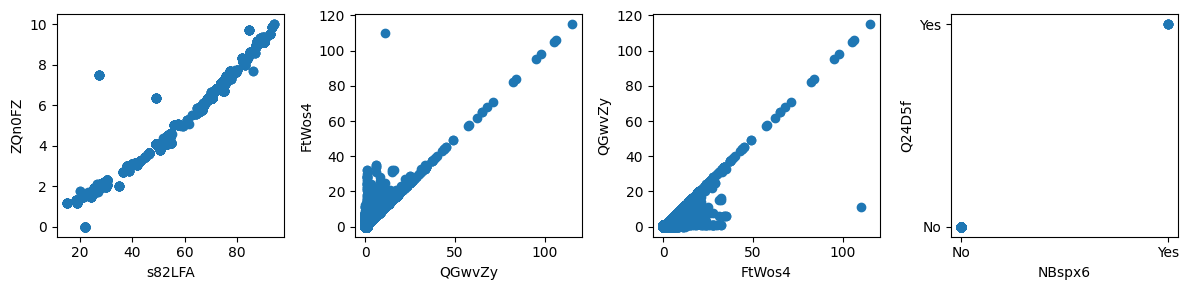

In [26]:
# Inspect some pairs with correlation > 0.9. The last (5th) plot has corr=1
pairs = [
    ['s82LFA', 'ZQn0FZ'],
    ['QGwvZy', 'FtWos4'],
    ['FtWos4', 'QGwvZy'],
    ['NBspx6', 'Q24D5f'],
]
fig, axs = plt.subplots(1, 4, figsize=(12, 3)) 

for i, p in enumerate(pairs):
    axs[i].scatter(data[p[0]], data[p[1]])
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])
    
plt.tight_layout()  

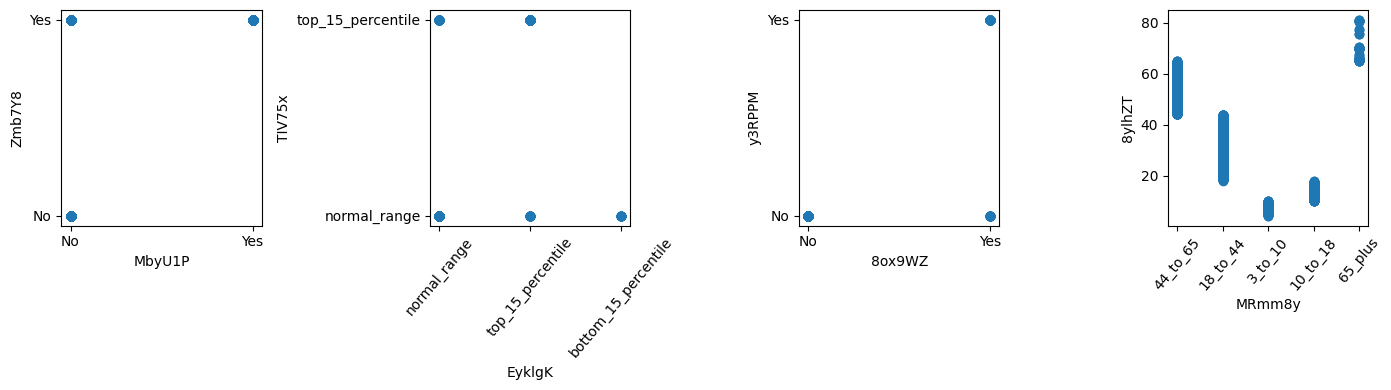

In [27]:
# Inspect some pairs with 0.9 > correlation > 0.8. 
# the fourth one is clearly age group by age
pairs = [
    ['MbyU1P', 'Zmb7Y8'],
    ['EyklgK', 'TIV75x'],
    ['8ox9WZ', 'y3RPPM'], 
    ['MRmm8y', '8ylhZT'],
]

fig, axs = plt.subplots(1, 4, figsize=(14, 4)) 

for i, p in enumerate(pairs):
    axs[i].scatter(data[p[0]], data[p[1]])
    axs[i].set_xlabel(p[0])
    if (i == 1) or (i == 3):
        plt.setp(axs[i].get_xticklabels(), rotation=50)
    axs[i].set_ylabel(p[1])
    
plt.tight_layout()

In [28]:
# Thus, in model fitting we can also drop highly correlated features
drop_features = list(corr_features['x2']) + drop_columns_single_value 
len(drop_features)

39

In [29]:
# write a pickle file
with open('drop_features.pickle', 'wb') as f:
    # Pickle the data list
    pickle.dump(drop_features, f)